# *supertrab - trabecular bone histomorphometry tests*
- segmentation of tacosound HR-pQCT data
- quantification of trabecular bone histomorphometry

Created on:  04.04.2025 <br />
Last update: 02.07.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk)
- Code license: MIT
- Narrative license: CC-BY-NC-SA

### Packages used in this notebook
- [ORMIR_XCT](https://github.com/ORMIR-XCT/ORMIR_XCT) is used for [segmenting the bone](https://github.com/SpectraCollab/ORMIR_XCT/blob/main/examples/Trabecular_Segmentation_Example.ipynb) and for the calculation of trabecular thickness in 3D
- [pyfabric](https://github.com/gianthk/pyfabric) contains notebooks showing how to segment and process 3D images of trabecular bone
- [recon_utils](https://github.com/gianthk/recon_utils) contains image processing utilities

---
# Computational workflow
## Configuration and imports

In [2]:
import os
import sys

In [3]:
# terminus
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/pyfabric')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/ORMIR_XCT')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/recon_utils')

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu, threshold_otsu, gaussian
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import SimpleITK as sitk

from imaging_utils import periosteummask, remove_unconnected
# from resources.myshow import myshow, myshow3d
from recon_utils import read_tiff_stack, plot_midplanes, bbox
# import pyfabric
# from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

astropy module not found
olefile module not found


In [5]:
from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics
from ormir_xct.segmentation.ipl_seg import ipl_seg, threshold_dict

In [6]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

## Load data
### LHDL microCT 19.5 um dataset
Scan Settings:
* voxelsize: 19.5 um

In [8]:
# LHDL microCT data
data_folder = '/usr/terminus/data-xrm-01/stamplab/external/LHTL/3155_D_4_bc/cropped/'

In [9]:
# Read the input data and define an array of the voxelsize
input_file = os.path.join(data_folder, '3155_D_4_bc_0000.tiff')
data_3D = read_tiff_stack(input_file)
# data_3D = np.rot90(read_tiff_stack(input_file), k=1, axes=(1, 2))
# data_3D = np.transpose(read_tiff_stack(input_file), axes=(1, 0, 2))

# voxelsize
vs = np.ones(3)*19.5e-3 # [mm]

### TacoSound HR-pQCT 30.3 um dataset

In [36]:
# 
data_folder = "/usr/terminus/data-xrm-01/stamplab/users/mwahlin/2025/trab_master/supertrab/patch_outputs"


mhd_file_path = os.path.join(data_folder, 'hr_patch.mhd')

data_3D = sitk.ReadImage(mhd_file_path, imageIO="MetaImageIO")
data_3D = sitk.GetArrayFromImage(data_3D)

# The patch comes with a -1 to 1 intensity range, so we need to scale it to 0-65535
scaling = 32768
# data_3D = (data_3D + 1) * 32768.

# voxelsize
vs = np.ones(3)*30.3e-3 # [mm]

Inspect the dataset

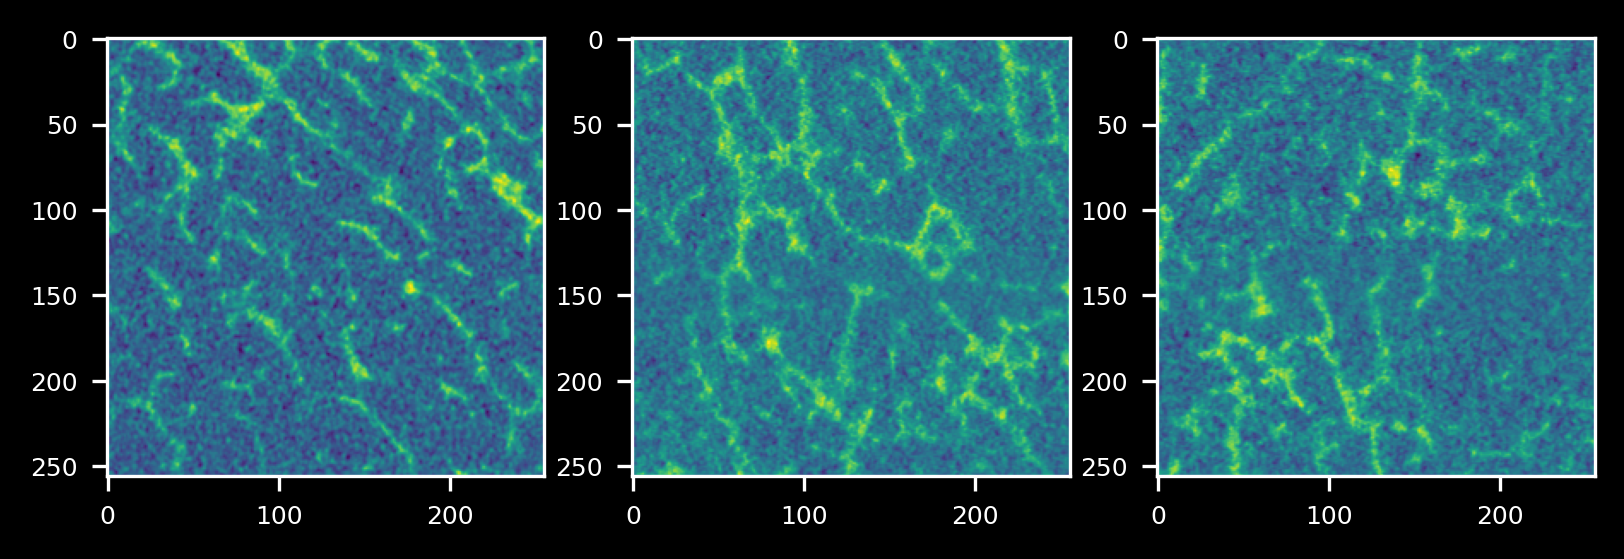

In [34]:
plot_midplanes(data_3D)

## Pre-processing
### Gaussian smooth

In [ ]:
# data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Image intensity histogram

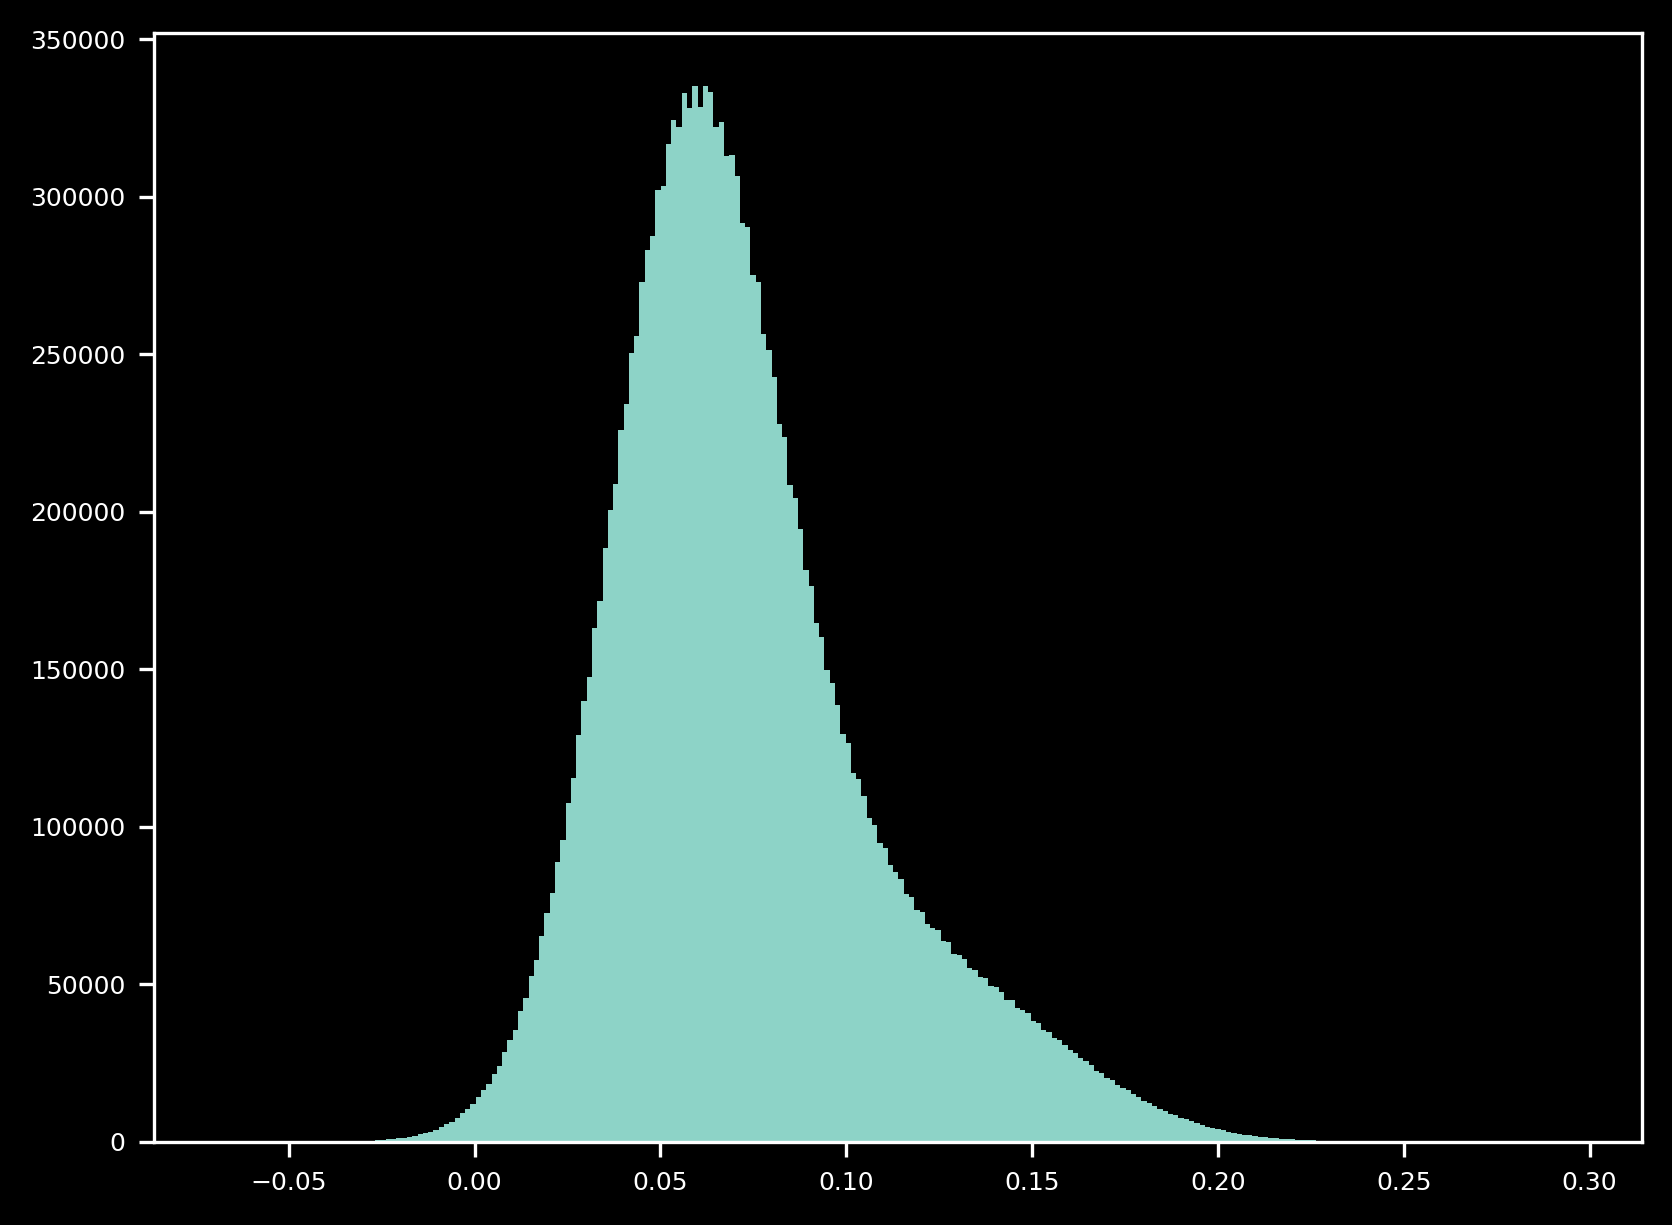

In [35]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=256)
plt.show()

## Segmentation
### Otsu thresholding

In [16]:
# calculate threshold using Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 0.0863083004951477


In [17]:
BW = data_3D > T

### For the LHTL dataset we can rely on a comparison with histology
We know that the real threshold value is 63

In [14]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

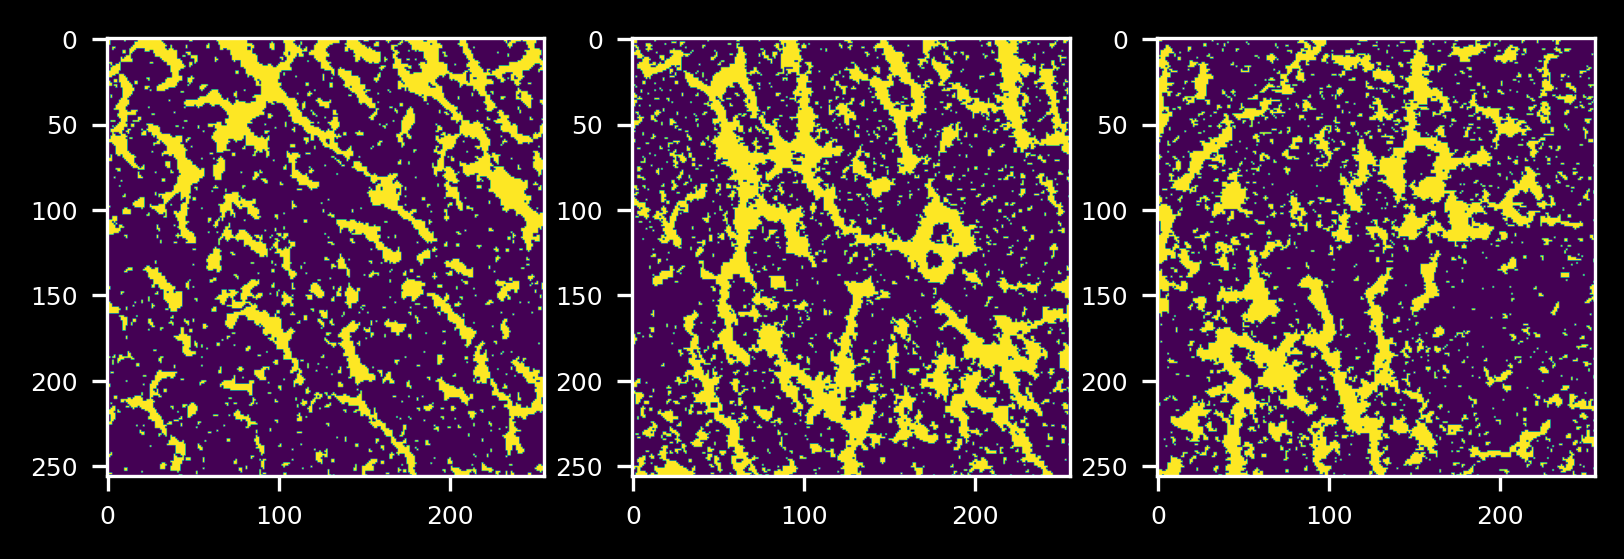

In [18]:
# inspect the binary mask
plot_midplanes(BW)

### Segmentation with `ormir_xct.ipl_seg`
#### Notes:
- Our image is not HU-converted, so the `HU_Lower` and `HU_Upper` values from `threshold_dict` will not work
- We need to set lower and upper threshold values based on the image intensity histogram

In [ ]:
threshold_dict

{'HU_Lower': 1170.0,
 'HU_Upper': 10000.0,
 'BMD_Lower': 446.8,
 'BMD_Upper': 3000.0,
 'Native_Lower': 4259.0,
 'Native_Upper': 32767.0,
 'LinAtt_Lower': 0.52,
 'LinAtt_Upper': 4.0,
 'Per1000_Lower': 130.0,
 'Per1000_Upper': 1000.0}

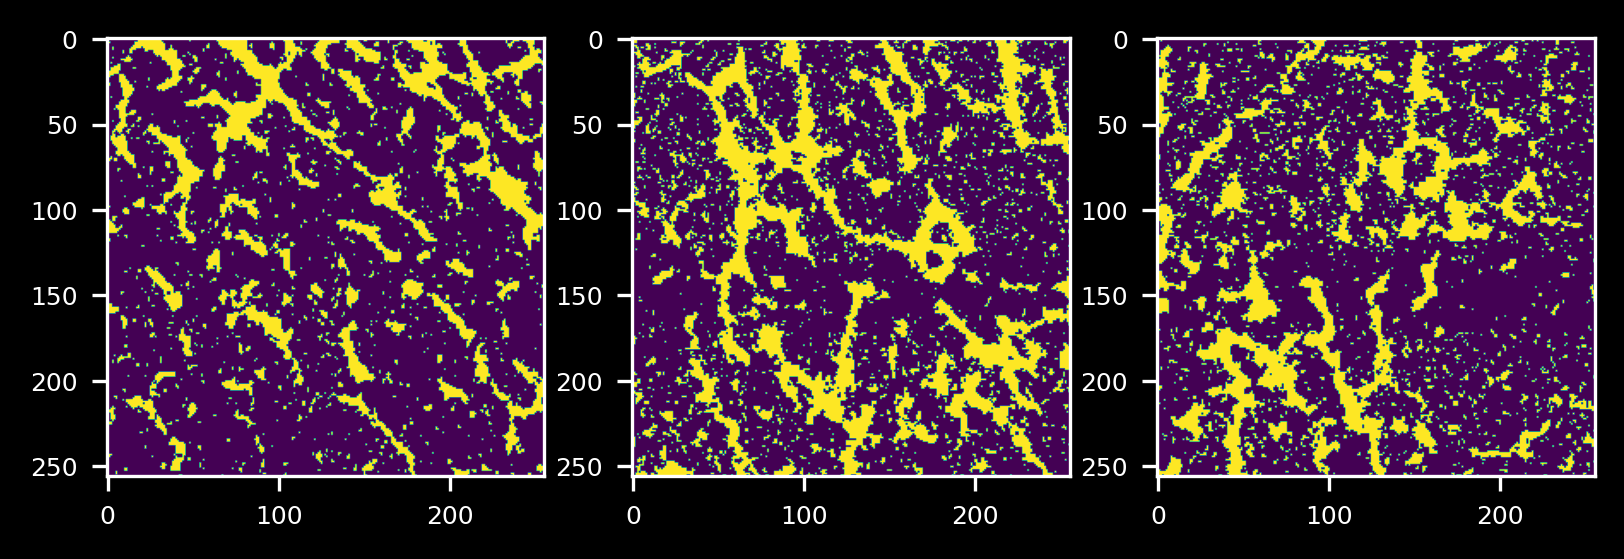

In [38]:
mu_water = 0.24090
mu_scaling = 8192
resale_slope = 1603.51904
rescale_intercept = -391.209015
lower_thresh = threshold_dict["BMD_Lower"]
upper_thresh = threshold_dict["BMD_Upper"]

BW = ipl_seg(
    sitk.GetImageFromArray(data_3D),
    lower_thresh/scaling,
    upper_thresh/scaling,
    voxel_size=vs[0],
    sigma=0.5,
)

# inspect the binary mask
plot_midplanes(sitk.GetArrayFromImage(~BW))

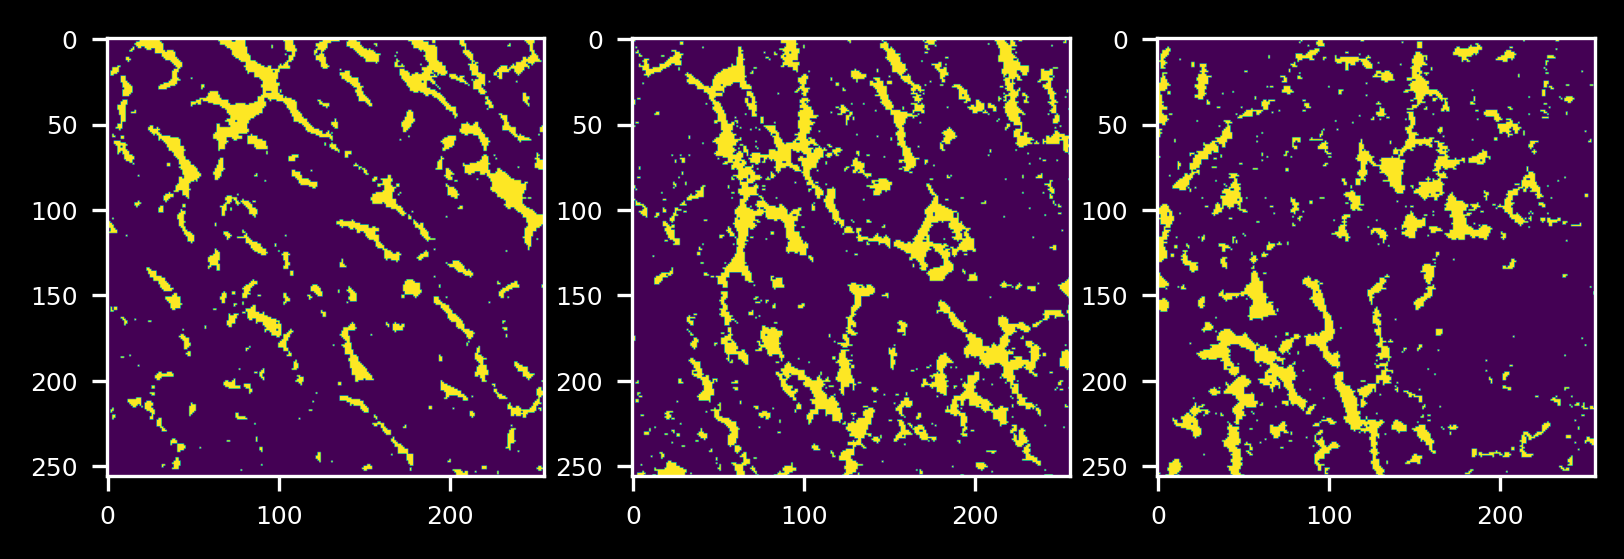

In [51]:
lower_thresh = 0.11
upper_thresh = 0.90

BW = ipl_seg(
    sitk.GetImageFromArray(data_3D),
    lower_thresh,
    upper_thresh,
    voxel_size=vs[0],
    sigma=1,
)

# inspect the binary mask
plot_midplanes(sitk.GetArrayFromImage(BW))

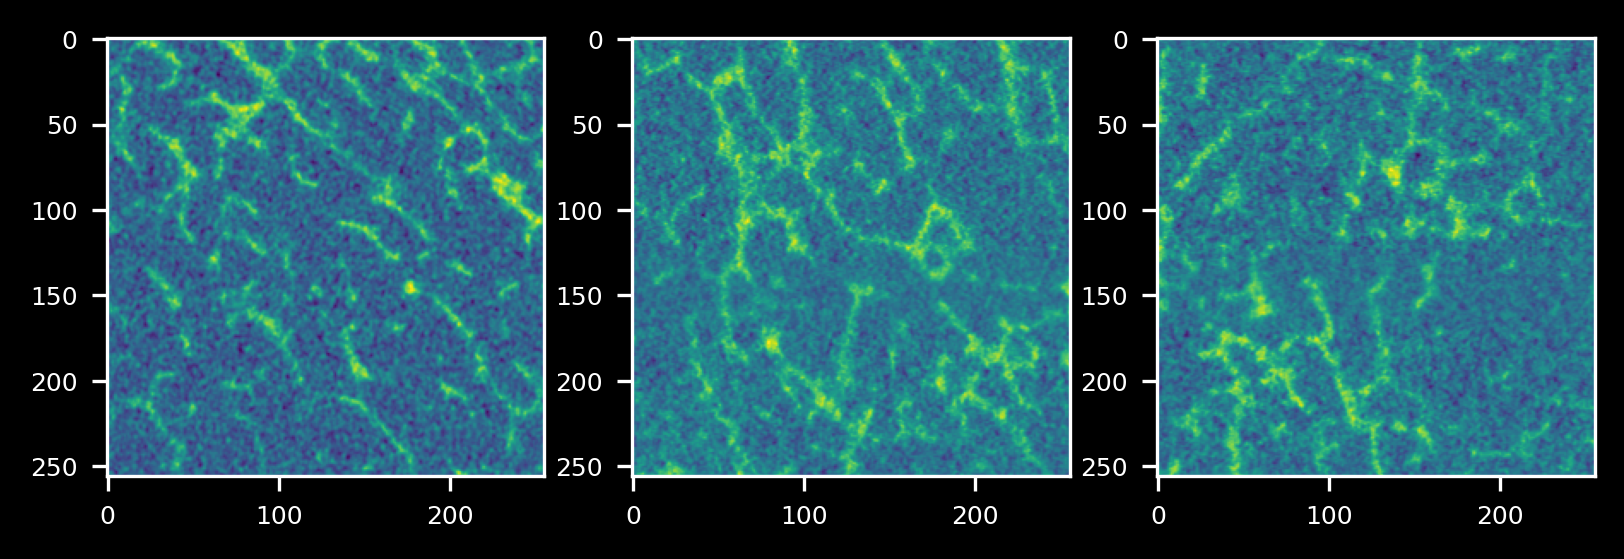

In [49]:
plot_midplanes(data_3D)

### Bounding Box of the specimen
A bounding box is the pixel coordinates of a box surrounding the sample. It is useful if you want to crop the parts of the 3D volume that contain only background

In [19]:
# bboxx = bbox(BW)
# print('bbox: ', bboxx)

In [20]:
# # crop the binary mask to the bounding box
# BW2 = BW[bboxx[0][2]:bboxx[1][2], bboxx[0][0]:bboxx[1][0], bboxx[0][1]:bboxx[1][1]].astype('bool')
# plot_midplanes(BW2)

## Binary mask operations
### Remove unconnected regions

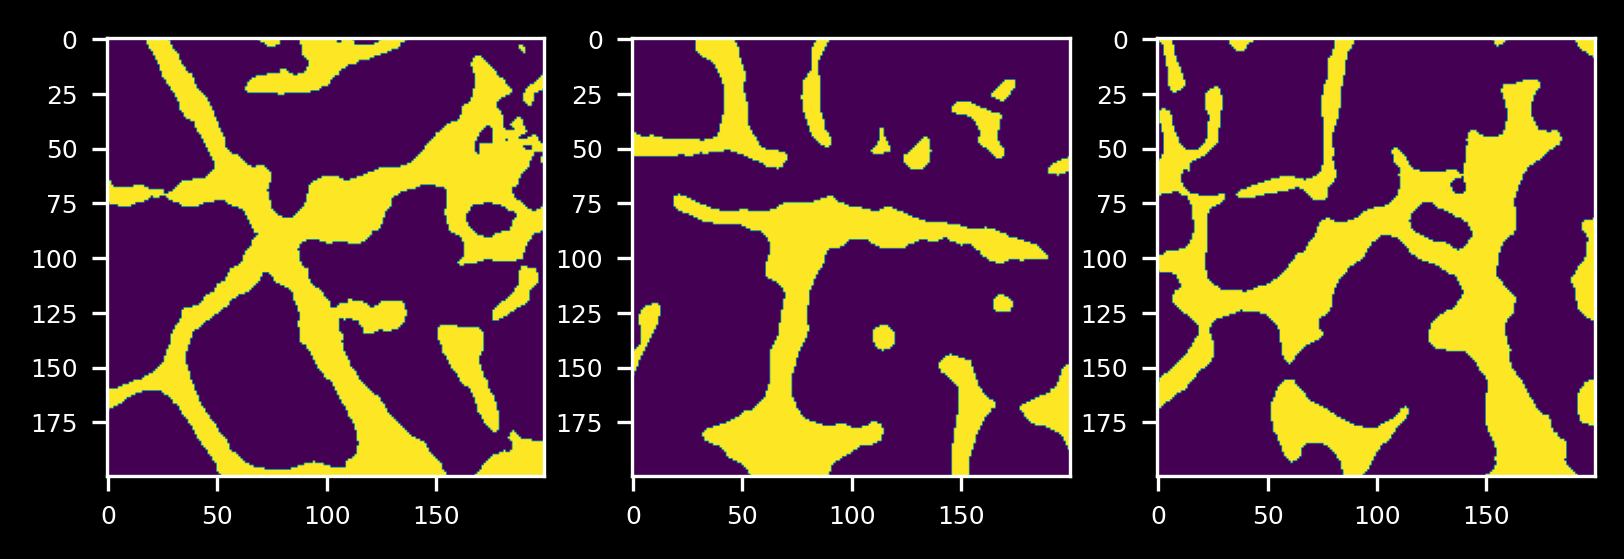

In [16]:
BW2 = remove_unconnected(BW)
plot_midplanes(BW2)

## Histomorphometry calculations
### BV/TV (bone volume fraction)

In [17]:
bvtv1 = np.sum(BW)/np.prod(BW.shape)
bvtv2 = np.sum(BW2)/np.prod(BW2.shape)
print('BV/TV: ', bvtv1)
print('BV/TV (without unconnected): ', bvtv2)

BV/TV:  0.2337425
BV/TV (without unconnected):  0.2336995


### Trabecular thickness (Tb.Th)

In [19]:
thickness_stats = calc_structure_thickness_statistics(BW2, vs, 0)
print(
    f"Thickness: {thickness_stats[0]:0.3f} +/- {thickness_stats[1]:0.3f}"
)

Thickness: 0.248 +/- 0.108


### Trabecular separation
Invert the mask and repeat Tb.Th calculation

In [20]:
separation_stats = calc_structure_thickness_statistics(~BW2, vs, 0)
print(
    f"Separation: {separation_stats[0]:0.3f} +/- {separation_stats[1]:0.3f}"
)

Separation: 0.786 +/- 0.219


## Modify the mask with binary erosion to reduce the Tb.Th

In [27]:
erosion_radius = 35*1e-3 # in [mm]
erosion_voxels = erosion_radius / vs[0]  # assuming isotropic voxels
print(f"Erosion radius: {erosion_radius} mm, voxels: {erosion_voxels}")
BW3 = morphology.binary_erosion(BW2, morphology.ball(1.8))

Erosion radius: 0.035 mm, voxels: 1.794871794871795


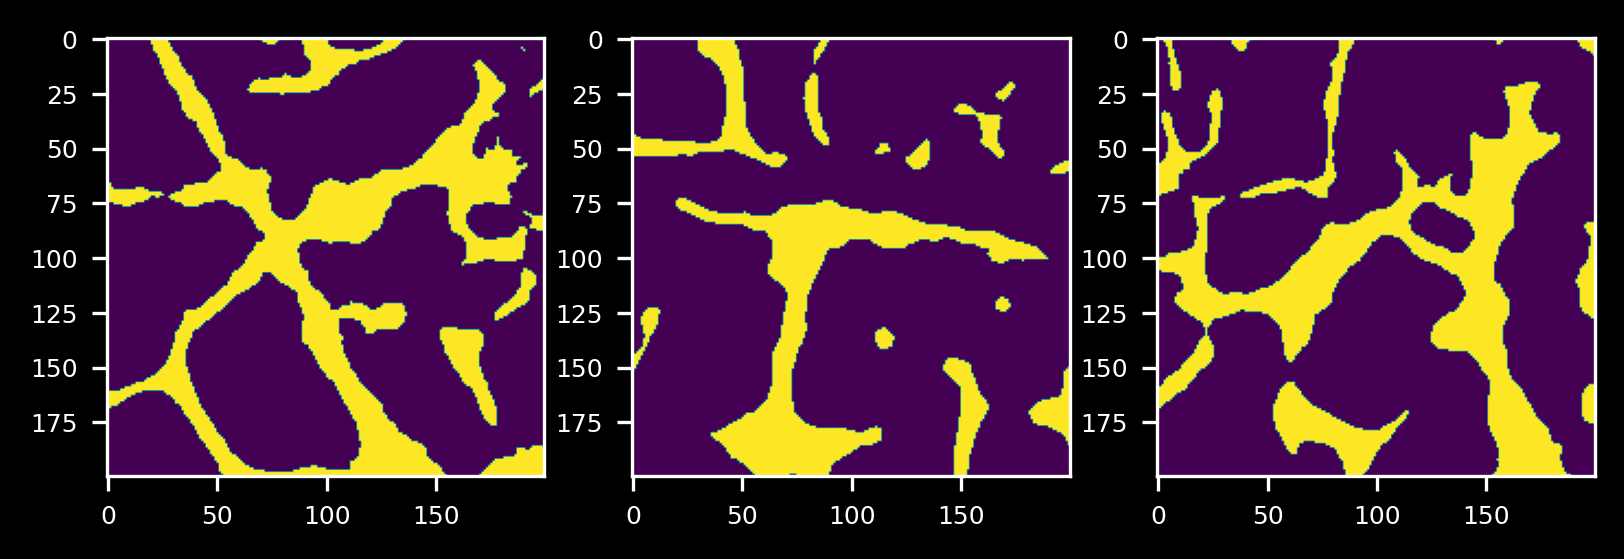

In [29]:
plot_midplanes(BW3)

### Recalculate Trabecular thickness (Tb.Th) after erosion

In [30]:
thickness_stats = calc_structure_thickness_statistics(BW3, vs, 0)
print(
    f"Thickness: {thickness_stats[0]:0.3f} +/- {thickness_stats[1]:0.3f}"
)

Thickness: 0.222 +/- 0.107


---
# Dependencies

In [99]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)